# Exploring lightning prediction setup

This notebook gets a set of grids and plots them to make sure we are pulling out training data correctly.
Read the [design doc](https://docs.google.com/document/d/1wmJN6G2f74aOZrqm2FJEkoeIQ_bvPz58FdAZr5SqSOk/edit) for more details.

In [ ]:
%%bash
source activate py2env
conda install -y pytz
pip uninstall -y google-cloud-dataflow
pip install --upgrade retrying snappy pyresample netcdf4  google-cloud-storage apache-beam[gcp]

After doing the pip install, Reset Session before continuing.

## Try out the local module

Make sure the local module works. This might take a couple of minutes.

In [2]:
%%bash
source activate py2env
python -m ltgpred.goesutil.goesio

/b/gcp-public-data-goes-16/o/ABI-L1b-RadC%2F2018%2F134%2F20%2FOR_ABI-L1b-RadC-M3C01_G16_s20181342002215_e20181342004588_c20181342005037.nc
8532 events; 8241 events; 7315 events; 9817 events; 8037 events; 10357 events; 7942 events; 7240 events; 6996 events; 7671 events; 8016 events; 8551 events; 8440 events; 7117 events; 9324 events; [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Read Infrared data

In [3]:
from __future__ import print_function
from __future__ import division
import ltgpred.goesutil.goesio as goesio
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
latlonres = 0.02
griddef = goesio.create_conus_griddef(latlonres)
irblob = goesio.get_ir_blob_paths(2018, 134, 20)[0] # top of the hour
ref = goesio.read_ir_data(irblob, griddef)

0.0


/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


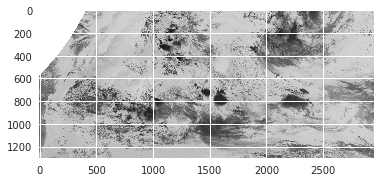

In [5]:
plt.imshow(ref);
print(ref[0,0])

## Read lightning data
Lightning data is actually just event observations every 20s. So we have to accumulate in a grid

In [6]:
# lightning blobs for 15 minutes as of the IR image
influence_km = 5
irdt = goesio.get_timestamp_from_filename(irblob)
ltg_blobs = goesio.get_ltg_blob_paths(irdt, timespan_minutes=15)
ltg = goesio.create_ltg_grid(ltg_blobs, griddef, influence_km)

8532 events; 8241 events; 7315 events; 9817 events; 8037 events; 10357 events; 7942 events; 7240 events; 7368 events; 7787 events; 8751 events; 7808 events; 8049 events; 8902 events; 8255 events; 8144 events; 9313 events; 7831 events; 8287 events; 6626 events; 7589 events; 10498 events; 7299 events; 6696 events; 8075 events; 9245 events; 9454 events; 7178 events; 7831 events; 7277 events; 8351 events; 8145 events; 7912 events; 9594 events; 8015 events; 7386 events; 7420 events; 7463 events; 6996 events; 7671 events; 8016 events; 8551 events; 8440 events; 7117 events; 9324 events; 

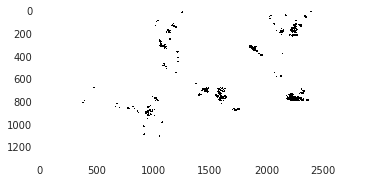

In [7]:
plt.imshow(ltg);

## Relationship between IR and lightning

Mean lightning as the reflectivity threshold is increased

In [10]:
def print_stats(name, data):
  print('{}: shape={}, mean={}, min={}, max={} count={}'.format(name, data.shape, np.mean(data), np.min(data), np.max(data), np.sum(~np.isnan(data))))
  return np.mean(data)

print_stats('ref', ref)
print_stats('ltg for all pixels', ltg)
print_stats('ref for ltg pixels', ref[ltg > 0.5])

ref: shape=(1300, 2950), mean=0.429475933313, min=0.0, max=1.0 count=3835000
ltg for all pixels: shape=(1300, 2950), mean=0.0124146023468, min=0.0, max=1.0 count=3835000
ref for ltg pixels: shape=(47610,), mean=0.721737682819, min=0.261066615582, max=1.0 count=47610


0.7217377

The average reflectivity associated with all pixels is 0.43 while the reflectivity associated with lightning pixels is 0.72.

In [11]:
frac = []
for thresh in np.arange(0, 1, 0.1):
  frac.append( print_stats('ltg where ref > {}'.format(thresh), ltg[ref > thresh]) )

ltg where ref > 0.0: shape=(3701795,), mean=0.0128613280854, min=0.0, max=1.0 count=3701795
ltg where ref > 0.1: shape=(3701795,), mean=0.0128613280854, min=0.0, max=1.0 count=3701795
ltg where ref > 0.2: shape=(3701795,), mean=0.0128613280854, min=0.0, max=1.0 count=3701795
ltg where ref > 0.3: shape=(3438062,), mean=0.0138153413173, min=0.0, max=1.0 count=3438062
ltg where ref > 0.4: shape=(1704052,), mean=0.0257891191114, min=0.0, max=1.0 count=1704052
ltg where ref > 0.5: shape=(1070853,), mean=0.0378856855236, min=0.0, max=1.0 count=1070853
ltg where ref > 0.6: shape=(642723,), mean=0.0571412568089, min=0.0, max=1.0 count=642723
ltg where ref > 0.7: shape=(295438,), mean=0.106563813727, min=0.0, max=1.0 count=295438
ltg where ref > 0.8: shape=(88084,), mean=0.261625266791, min=0.0, max=1.0 count=88084
ltg where ref > 0.9: shape=(3196,), mean=0.572903629537, min=0.0, max=1.0 count=3196


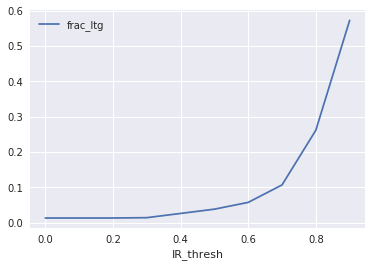

In [17]:
import pandas as pd
df = pd.DataFrame({
  'IR_thresh': np.arange(0,1, 0.1),
  'frac_ltg': frac
})
df.plot('IR_thresh', 'frac_ltg');

How about 30 minutes into the future?

10345 events; 9446 events; 9458 events; 8479 events; 9717 events; 8823 events; 7679 events; 9065 events; 8821 events; 9369 events; 8834 events; 12393 events; 9143 events; 9278 events; 8489 events; 8973 events; 9076 events; 9914 events; 10227 events; 9171 events; 9749 events; 10301 events; 9100 events; 9439 events; 8953 events; 8891 events; 8765 events; 9525 events; 12106 events; 10295 events; 10581 events; 9694 events; 11359 events; 8908 events; 8676 events; 9375 events; 9727 events; 10896 events; 12553 events; 11331 events; 15492 events; 10813 events; 10368 events; 13694 events; 10158 events; ltg where ref > 0.0: shape=(3701795,), mean=0.0137860146226, min=0.0, max=1.0 count=3701795
ltg where ref > 0.1: shape=(3701795,), mean=0.0137860146226, min=0.0, max=1.0 count=3701795
ltg where ref > 0.2: shape=(3701795,), mean=0.0137860146226, min=0.0, max=1.0 count=3701795
ltg where ref > 0.3: shape=(3438062,), mean=0.0147978715916, min=0.0, max=1.0 count=3438062
ltg where ref > 0.4: shape=(170

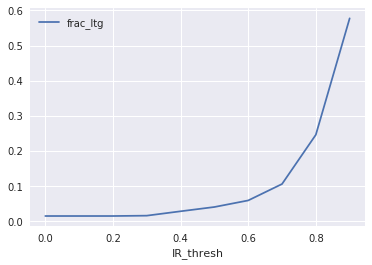

In [20]:
from datetime import timedelta
ltg30_blobs = goesio.get_ltg_blob_paths(irdt + timedelta(minutes=30), timespan_minutes=15)
ltg30 = goesio.create_ltg_grid(ltg30_blobs, griddef, influence_km)
frac = []
for thresh in np.arange(0, 1, 0.1):
  frac.append( print_stats('ltg where ref > {}'.format(thresh), ltg30[ref > thresh]) )
df = pd.DataFrame({
  'IR_thresh': np.arange(0,1, 0.1),
  'frac_ltg': frac
})
df.plot('IR_thresh', 'frac_ltg');

In [ ]:
print(griddef.lats)

Once we get to a reflectivity threshold of 0.9, then 57% of the pixels are associated with lightning.

## Create training examples from IR and lightning

See if there is signal by doing a bit of feature engineering on the ref array and then using scikit-learn

In [ ]:
N = 32
strideN = N
halfN = N//2
N15 = N + halfN

def get_prediction_grid_centers(ref): 
  cy, cx = np.meshgrid(np.arange(N15, ref.shape[0]-N15, strideN),
                       np.arange(N15, ref.shape[1]-N15, strideN))
  cy = cy.ravel()
  cx = cx.ravel()
  return zip(cy, cx)

def rawdata_input_fn(ref, ltg, griddef):
  for cy, cx in get_prediction_grid_centers(ref):
    # restrict to grids where there is lightning in the area
    interesting = np.sum(ltg[cy-N15:cy+N15, cx-N15:cx+N15]) > 0.5
    if interesting:
      label = np.sum(ltg[cy-halfN:cy+halfN, cx-halfN:cx+halfN]) > 0.5
      example = {
          'lon': griddef.lons[cy][cx],
          'lat': griddef.lats[cy][cx], 
          'ref_smallbox': ref[cy-halfN:cy+halfN, cx-halfN:cx+halfN],
          'ref_bigbox': ref[cy-N15:cy+N15, cx-N15:cx+N15],
          'has_ltg': label #1.0 if label else 0.0
      }
      yield example

def create_prediction_df(ref, ltg, griddef):
  data = []
  for example in rawdata_input_fn(ref, ltg, griddef):
    data.append([example['lat'],
                 example['lon'],
                 np.mean(example['ref_smallbox']), # mean within subgrid
                 np.max(example['ref_smallbox']),
                 np.mean(example['ref_bigbox']),
                 np.max(example['ref_bigbox']),
                 example['has_ltg']
                ])

  import pandas as pd
  df = pd.DataFrame(data, columns=['lat', 'lon', 'meanref_smallbox', 'maxref_smallbox', 'meanref_bigbox', 'maxref_bigbox', 'ltg'])
  print('For lightning grids {}'.format(df[df['ltg']].describe()))
  print('For no-lightning grids {}'.format(df[~df['ltg']].describe()))
  return df

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
model = LogisticRegression()
df = create_prediction_df(ref, ltg, griddef)
x = df.drop(['lat', 'lon', 'ltg'], axis=1)
model = model.fit(x, df['ltg'] > 0.5)
print(model.coef_, model.intercept_)
print('Model accuracy={}%'.format(100*model.score(x, df['ltg'])))

We can detect lightning reasonably well based on just the IR temperature.

## Predicting lightning

How about if we try to predict lightning 30 minutes into the future?

In [ ]:
from datetime import timedelta

ltg30_blobs = goesio.get_ltg_blob_paths(irdt + timedelta(minutes=30), timespan_minutes=15)
ltg30 = goesio.create_ltg_grid(ltg30_blobs, griddef, influence_km)

model = LogisticRegression()
df = create_prediction_df(ref, ltg30, griddef)
x = df.drop(['lat', 'lon', 'ltg'], axis=1)
model = model.fit(x, df['ltg'])
print(model.coef_, model.intercept_)
print('Model accuracy={}%'.format(100*model.score(x, df['ltg'])))

Not bad at all!  We got accuracy of 74% predicting lightning 30 minutes into the future. Of course, this is training & validation on the same hour of data.

## Visualize the prediction

The prediction grid has a resolution that is N times coarser than the original because we were predicting only at the centers (we could always do it at a finer resolution though, by reducing strideN).

In [ ]:
df['predicted'] = model.predict_proba(x)
df.head()

In [ ]:
import pyresample as pr
swath_def = pr.geometry.SwathDefinition(lats=df['lat'], lons=df['lon'])
ltgpred = pr.kd_tree.resample_nearest(swath_def, df['predicted'].values, griddef, radius_of_influence=1000*latlonres*100*N, epsilon=0.5)
plt.imshow(ltgpred);

## Beam pipeline to create training dataset

The above was on just one hour of data.  Here's the start of a Beam pipeline that will generate a list of training and evaluation dataset hours. 

In [ ]:
import apache_beam as beam
import shutil
import os

def generate_hours(starthour, endhour, startday, endday, startyear, endyear, is_train):
  for h in xrange(starthour, endhour+1):
    for d in xrange(startday, endday+1):
      for y in xrange(startyear, endyear+1):
        data = {
          'hour': h,
          'day': d,
          'year': y
        }
        if hash(str(data)) % 10 < 7:
          if is_train:
            yield data
        else:
          if not is_train:
            yield data

OUTPUT_DIR = './preproc'
RUNNER = 'DirectRunner'
options = {
      'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
      'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
      'job_name': 'hello',
      'project': 'cloud-training-demos',
      'teardown_policy': 'TEARDOWN_ALWAYS',
      'no_save_main_session': True
}
opts = beam.pipeline.PipelineOptions(flags = [], **options)
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
p = beam.Pipeline(RUNNER, options=opts)

for step in ['train', 'eval']:
  (p 
   | '{}_hours'.format(step) >> beam.Create(generate_hours(12, 14, 183, 184, 2018, 2018, step == 'train'))
   | '{}_write'.format(step) >> beam.io.Write(beam.io.WriteToText(os.path.join(OUTPUT_DIR, step)))
  )

job = p.run()
job.wait_until_finish()

In [ ]:
!head preproc/*

Let's invoke the above functions, and put it into our Python module.

In [ ]:
%bash
source activate py2env
python -m ltgpred.preproc.create_dataset \
   --outdir=./preproc \
   --startday 183 --endday 183  --starthour 13  --endhour 13 --lightning_validity 2

More beam trials ...

In [ ]:
import apache_beam as beam
import datetime
[1, 2, 3] | beam.Map(lambda x : datetime.datetime(2018,x,1))

In [ ]:
import apache_beam as beam
import numpy as np

class MeanStddev(beam.CombineFn):
  def create_accumulator(self):
    return (0.0, 0.0, 0) # x, x^2, count

  def add_input(self, sum_count, input):
    (sum, sumsq, count) = sum_count
    return sum + input, sumsq + input*input, count + 1

  def merge_accumulators(self, accumulators):
    sums, sumsqs, counts = zip(*accumulators)
    return sum(sums), sum(sumsqs), sum(counts)

  def extract_output(self, sum_count):
    (sum, sumsq, count) = sum_count
    if count:
      mean = sum / count
      variance = (sumsq / count) - mean*mean
      # -ve value could happen due to rounding
      stddev = np.sqrt(variance) if variance > 0 else 0
      return {
        'mean': mean,
        'variance': variance,
        'stddev': stddev,
        'count': count
      }
    else:
      return {
        'mean': float('NaN'),
        'variance': float('NaN'),
        'stddev': float('NaN'),
        'count': 0
      }
    
    
#[1.3, 3.0, 4.2] | beam.CombineGlobally(MeanStddev())

#[('a', 1.3), ('a', 3.0), ('b', 4.2)] | beam.CombinePerKey(MeanStddev())

[
  {'a': 1.3, 'b': 2.3, 'c': 4.5},
  {'a': 2.3, 'b': 3.3, 'c': 5.4},  
] | beam.FlatMap(lambda x : [(f, x[f]) for f in ['a', 'b']]) | beam.CombinePerKey(MeanStddev())

In [ ]:
%bash
gsutil cat gs://cloud-training-demos-ml/lightning/preproc/stats/*

In [ ]:
value = np.ma.array([[0.3, 10, 0.8], [-2.8, np.nan, np.inf]], 
                    mask=[[False, True, False], [False, False, False]])
print(value)
x = np.ma.filled(value.flatten(), np.nan)
print(x)
x = np.nan_to_num(x)
print(x)
x = np.clip(x, -1, 1)
print(x)

## Run Beam pipeline at scale

Run on all available days in 2018.

In [ ]:
%%bash
source activate py2env

PROJECT='cloud-training-demos'
BUCKET='cloud-training-demos-ml'
LATLONRES=0.02
TRAIN_RADIUS=32
LABEL_RADIUS=2
STRIDE=4 # use 2*label_patch_radius
OUTDIR=gs://${BUCKET}/lightning/preproc_${LATLONRES}_${TRAIN_RADIUS}_${LABEL_RADIUS}
gsutil -m rm -rf $OUTDIR

python -m ltgpred.preproc.create_dataset \
   --outdir=$OUTDIR \
   --startyear 2018 --endyear 2018 --startday 45 --endday 350 --project=$PROJECT \
   --train_patch_radius=$TRAIN_RADIUS --label_patch_radius=$LABEL_RADIUS --stride=$STRIDE --latlonres=$LATLONRES

## More data, harder problem

In [ ]:
%%bash
source activate py2env

PROJECT='cloud-training-demos'
BUCKET='cloud-training-demos-ml'
LATLONRES=0.02
TRAIN_RADIUS=32
LABEL_RADIUS=1
STRIDE=2 # use 2*label_patch_radius
LTG_VALID_TIME=5
OUTDIR=gs://${BUCKET}/lightning/preproc_${LATLONRES}_${TRAIN_RADIUS}_${LABEL_RADIUS}
gsutil -m rm -rf $OUTDIR

python -m ltgpred.preproc.create_dataset \
   --outdir=$OUTDIR \
   --startyear 2018 --endyear 2018 --startday 45 --endday 350 --project=$PROJECT \
   --train_patch_radius=$TRAIN_RADIUS --label_patch_radius=$LABEL_RADIUS \
   --stride=$STRIDE --latlonres=$LATLONRES --lightning_validity=$LTG_VALID_TIME

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the \"License\"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an \"AS IS\" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License